In [2]:
from typing import List, Dict, Iterable, Tuple, Callable
from matplotlib import pyplot as plt
from collections import Counter
# import pygal
import sys
import os
import string
import urllib.request
import requests
import curl
import pycurl
import webbrowser
import numpy as np
import math
import pandas as pd
# from IPython import qt
from matplotlib.pyplot import figure
from py.xml import raw
from requests.api import get
from matplotlib import pyplot as plt
# from scratch.working_with_data import rescale
# from scratch.multiple_regression import least_squares_fit, predict
# from scratch.gradient_descent import gradient_step

# from stats import mean, median, de_mean, standard_deviation, correlation
# from gradient_descent import minimize_stochastic, maximize_stochastic, maximize_batch
# from vector import dot, vector_add
# from normal import normal_cdf
# from matrix import make_matrix, get_column, shape, matrix_multiply
# from logistic_regression import *

import math
import os
import random
import sys
from functools import partial, reduce

from scipy.optimize import fmin_tnc

import tqdm

from typing import*

from collections import*


In [3]:
# Functions

# def add(a, b): return a + b

def vector_sum(vectors):
    """Sums all corresponding elements"""
    # Check that vectors is not empty
    assert vectors, "no vectors provided!"

    # Check the vectors are all the same size
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"

    # the i-th element of the result is the sum of every vector[i]
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]

def scalar_multiply(c , v):
    """Multiplies every element by c"""
    return [c * v_i for v_i in v]

def vector_mean(vectors):
    """Computes the element-wise average"""
    n = len(vectors)
    m = np.sum(vectors,axis=0)
    vec_mean = np.multiply(1/n,m)
    return vec_mean

def de_mean(xs):
    """Translate xs by subtracting its mean (so the result has mean 0)"""
    x_bar = np.mean(xs)
    d_mean = [x - x_bar for x in xs]
    return d_mean

def dot(v, w):
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v):
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def variance(xs):
    """Almost the average squared deviation from the mean"""
    assert len(xs) >= 2, "variance requires at least two elements"

    n = len(xs)
    deviations = de_mean(xs)
    vari = sum_of_squares(deviations)/(n-1)
    return vari

# Standard deviation                        
def standard_deviation(xs):
    """The standard deviation is the square root of the variance"""
    std_dev = np.sqrt(variance(xs)) 
    return std_dev

def scale(data):
    """returns the mean and standard deviation for each position"""
    dim = data.shape[0]
    
    # Vector Mean
#     n = len(data)
#     m = np.sum(data,axis=0)
#     means = np.multiply(1/n,m)
    means = vector_mean(data)
    
    # Standard Deviaiton
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]
    return means,stdevs

def rescale(data):
    """
    Rescales the input data so that each position has
    mean 0 and standard deviation 1. (Leaves a position
    as is if its standard deviation is 0.)
    """
    dim = data.shape[0]
    means, stdevs = scale(data)
    
    means = list(means)
    stdevs = list(stdevs)

    # Make a copy of each vector
    rescaled = [v[:] for v in data]
    v0 = []
    for v in rescaled:
        v = list(v)
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]
        v0.append(v)

    return v0

def gradient_step(v, gradient, step_size):
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    grad_step = np.add(v,step)
    return grad_step

# def predict(alpha, beta, x_i):
#     pred = beta * x_i + alpha
#     return pred

# def error(x, y, beta):
#     """
#     The error from predicting beta * x_i + alpha
#     when the actual value is y_i
#     """
#     err_fin = predict(alpha, beta, x_i) - y_i
#     return err_fin

def predict(x, beta):
    """assumes that the first element of x is 1"""
    return dot(x, beta)

def error(x, y, beta):
    return predict(x, beta) - y 

def sqerror_gradient(x, y, beta):
    err = error(x, y, beta)
    err_fin = [2 * err * x_i for x_i in x]
    return err_fin

def least_squares_fit(xs, ys, learning_rate = 0.001, num_steps = 1000, batch_size = 1):
    """
    Find the beta that minimizes the sum of squared errors
    assuming the model y = dot(x, beta).
    """
    # Start with a random guess
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="least squares fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess)
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    y = logistic(x)
    return y * (1 - y)

def _negative_log_likelihood(x, y, beta):
    """The negative log likelihood for one data point""" 
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))
    
def negative_log_likelihood(xs, ys, beta):
    return sum(_negative_log_likelihood(x, y, beta)
               for x, y in zip(xs, ys))

def _negative_log_partial_j(x, y, beta, j):
    """
    The jth partial derivative for one data point.
    Here i is the index of the data point.
    """
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x, y, beta):
    """
    The gradient for one data point.
    """
    return [_negative_log_partial_j(x, y, beta, j)
            for j in range(len(beta))]

def negative_log_gradient(xs, ys,beta):
    return vector_sum([_negative_log_gradient(x, y, beta)
                       for x, y in zip(xs, ys)])

def split_data(data, prob):
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

def train_test_split(xs, ys, test_pct):
     # Generate the indices and split them
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)

    return ([xs[i] for i in train_idxs],  # x_train 
            [xs[i] for i in test_idxs],   # x_test
            [ys[i] for i in train_idxs],  # y_train
            [ys[i] for i in test_idxs])   # y_test
                                                                



In [4]:
df = pd.read_csv("golf3.txt")
df.head(15)

,Outlook,Temp,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,25
1,Sunny,Hot,High,Strong,30
2,Overcast,Hot,High,Weak,46
3,Rain,Mild,High,Weak,45
4,Rain,Cool,Normal,Weak,52
5,Rain,Cool,Normal,Strong,23
6,Overcast,Cool,Normal,Strong,43
7,Sunny,Mild,High,Weak,35
8,Sunny,Cool,Normal,Weak,38
9,Rain,Mild,Normal,Weak,46


In [5]:
# class Candidate(NamedTuple):
#     outlook: str
#     temp: str
#     hum: str
#     wind: str       
#     decision: float # allow unlabeled data


# # inputs=[]
# # for i in range(len(df)):
# #     inputs.append(Candidate(df['Outlook'][i],df['Temp'][i]),df['Humidity'][i], df['Wind'][i], df['Decision'][i])

# # Generic type of inputs
# T = TypeVar('T')
# # df['Outlook'][1]
# # inputs
# # inputs.append(Candidate(df['Outlook'][i],df['Temp'][i]),df['Humidity'][i], df['Wind'][i], df['Decision'][i])

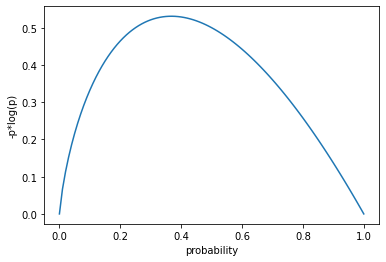

In [6]:
x = [i/100.0 for i in range(101) ]
entropy_x = [0] + [-p*math.log(p,2) for p in x if p > 0]
# import matplotlib.pyplot as plt
plt.plot(x, entropy_x)
plt.xlabel('probability')
plt.ylabel('-p*log(p)')
plt.show()

In [7]:
# Entropy
def entropy(class_probabilities):
    """Given a list of class probabilities, compute the entropy"""
    ent = sum(-p * math.log(p, 2)
               for p in class_probabilities 
               if p > 0)
#     ent_0 = []
#     for p in class_probabilities :
#         if p > 0:
#             ent_0.append(-p * math.log(p,2))
#     ent = sum(ent_0)
            
    return ent

def class_probabilities(labels):
    total_count = len(labels)
    class_prob = [count / total_count for count in Counter(labels).values()]
    return class_prob

def data_entropy(labels):
    data_ent = entropy(class_probabilities(labels))
    return data_ent



In [8]:
# The Entropy of a Partition

def partition_entropy(subsets):
    """Returns the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    part_ent = sum(data_entropy(subset) * len(subset) / total_count for subset in subsets)

    return part_ent


In [9]:
# Creating a Decision Tree using Panda
outlook = df['Outlook']
temp = df['Temp']
humidity = df['Humidity']
wind = df['Wind']
decision = df['Decision']

class Candidate(NamedTuple):
    outlook: str
    temp: str
    humidity: str
    wind: str
    decision: Optional[float] = None  # allow unlabeled data
        
# inputs = Candidate(outlook,temp,humidity,wind,decision)

inputs = []
for i in range(len(df)):
    inputs.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],decision[i]))
inputs

[Candidate(outlook='Sunny', temp='Hot', humidity='High', wind='Weak', decision=25),
 Candidate(outlook='Sunny', temp='Hot', humidity='High', wind='Strong', decision=30),
 Candidate(outlook='Overcast', temp='Hot', humidity='High', wind='Weak', decision=46),
 Candidate(outlook='Rain', temp='Mild', humidity='High', wind='Weak', decision=45),
 Candidate(outlook='Rain', temp='Cool', humidity='Normal', wind='Weak', decision=52),
 Candidate(outlook='Rain', temp='Cool', humidity='Normal', wind='Strong', decision=23),
 Candidate(outlook='Overcast', temp='Cool', humidity='Normal', wind='Strong', decision=43),
 Candidate(outlook='Sunny', temp='Mild', humidity='High', wind='Weak', decision=35),
 Candidate(outlook='Sunny', temp='Cool', humidity='Normal', wind='Weak', decision=38),
 Candidate(outlook='Rain', temp='Mild', humidity='Normal', wind='Weak', decision=46),
 Candidate(outlook='Sunny', temp='Mild', humidity='Normal', wind='Strong', decision=48),
 Candidate(outlook='Overcast', temp='Mild', hu

In [10]:
# Overcast
overcast = []
for i in range(0,len(inputs)):
    if inputs[i][0] == 'Overcast':
        overcast.append(inputs[i][4])
        
overcast = np.mean(overcast)
overcast

46.25

In [11]:
# Create lists of labels
outlook_labels = [] 
temp_labels = []
hum_labels = []
wind_labels = []

inputs[2][0]

for i in range(len(inputs)):
    if inputs[i][0] not in outlook_labels:
        outlook_labels.append(inputs[i][0])
    if inputs[i][1] not in temp_labels:
        temp_labels.append(inputs[i][1])
    if inputs[i][2] not in hum_labels:
        hum_labels.append(inputs[i][2])
    if inputs[i][3] not in wind_labels:
        wind_labels.append(inputs[i][3])
        

# wind_labels
# inputs

In [12]:
# Weather - Rain

w1 = {}
w1_prob = {}
# for j in range(len(temp_labels)):
for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs)):
        if inputs[i][0] == 'Rain' and inputs[i][3] == wind_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs[i][4])
#             print(weather)
    w1[wind_labels[j]] = weather
    w1_prob[wind_labels[j]]  = np.mean(weather)

rain_wind = w1_prob

for j in range(len(w1_prob)):
    weather_rain = 'rain_wind' + str(wind_labels[j])
    rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
#     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# inputs[5][0]
# weather = np.mean(weather)
# weather
w1
w1_prob
# weather
# rain_wind_weak = rain_wind['Weak']
# rain_wind_strong = rain_wind['Strong']
# rain_wind_strong

# foo = 'rain_wind_strong_2'
# foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# print(rain_wind_strong)
w1_prob

{'Weak': 47.666666666666664, 'Strong': 26.5}

In [13]:
# Weather - Sunny
w1 = {}
w1_prob = {}
# for j in range(len(temp_labels)):
for j in range(0,len(temp_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs)):
        if inputs[i][0] == 'Sunny' and inputs[i][1] == temp_labels[j]:
#             weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
#             sun = exec(weather_sun + '=' + str(inputs[i][4]))
            weather.append(inputs[i][4])
#             print(weather)
    w1[temp_labels[j]] = weather
    w1_prob[temp_labels[j]]  = np.mean(weather)
    

sunny_temp = w1_prob

for j in range(len(w1_prob)):
    weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
    sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))
    

# # inputs[5][0]
# # weather = np.mean(weather)
# # weather
# w1
w1_prob
# # weather
# rain_wind_weak = rain_wind['Weak']
# rain_wind_strong = rain_wind['Strong']
# rain_wind_strong
sun_temp_hot = sunny_temp['Hot']
sun_temp_mild = sunny_temp['Mild']
sun_temp_cool = sunny_temp['Cool']
print('Sunny_temp1:',sun_temp_hot)
sunny_temp_mild

aad = w1_prob.values()
list(aad)
# for i in list(aad):
#     print(i)
    
# w1_prob[temp_labels[0]]
print('Sunny_temp2:',sunny_temp_hot)
w1_prob['Hot']

Sunny_temp1: 27.5
Sunny_temp2: 27.5


27.5

In [14]:
# Creating a Decision Tree

# Test
# Create class
# class Candidate(NamedTuple):
#     level: str
#     lang: str
#     tweets: bool
#     phd: bool
#     did_well: Optional[bool] = None  # allow unlabeled data
# # Data
# inputs = [Candidate('Senior', 'Java',   False, False, False),
#           Candidate('Senior', 'Java',   False, True,  False),
#           Candidate('Mid',    'Python', False, False, True),
#           Candidate('Junior', 'Python', False, False, True),
#           Candidate('Junior', 'R',      True,  False, True),
#           Candidate('Junior', 'R',      True,  True,  False),
#           Candidate('Mid',    'R',      True,  True,  True),
#           Candidate('Senior', 'Python', False, False, False),
#           Candidate('Senior', 'R',      True,  False, True),
#           Candidate('Junior', 'Python', True,  False, True),
#           Candidate('Senior', 'Python', True,  True,  True),
#           Candidate('Mid',    'Python', False, True,  True),
#           Candidate('Mid',    'Java',   True,  False, True),
#           Candidate('Junior', 'Python', False, True,  False)
#          ]

# Generic type of inputs
T = TypeVar('T')

def partition_by(inputs, attribute):
    """Partition the inputs into lists based on the specified attribute."""
    partitions: Dict[Any, List[T]] = defaultdict(list)
    for input in inputs:
        key = getattr(input, attribute)  # value of the specified attribute
        partitions[key].append(input)    # add input to the correct partition
    return partitions

# Compute Entropy
def partition_entropy_by(inputs, attribute, label_attribute):
    """Compute the entropy corresponding to the given partition"""
    # partitions consist of our inputs 
    partitions = partition_by(inputs, attribute)

    # but partition_entropy needs just the class labels
    labels = [[getattr(input, label_attribute) for input in partition]
              for partition in partitions.values()]

    return partition_entropy(labels)

for key in ['outlook','temp','humidity','wind']:
    print(key, partition_entropy_by(inputs, key, 'decision'))

# partition_entropy_by(inputs, 'level', 'did_well')

# senior_inputs = [input for input in inputs if input.level == 'Senior']

# senior_inputs

# type(senior_inputs)
inputs
type(inputs)

outlook 2.2299486392052588
temp 2.250698214594781
humidity 2.6644977792004614
wind 2.536412500309067


list

In [15]:
# Putting It All Together

class Leaf(NamedTuple): 
     value: Any
            
class Split(NamedTuple):
    attribute:Any
    subtrees: dict
    default_value: Any = None

DecisionTree = Union[Leaf, Split]

# Representation
# hiring_tree = Split('level', {   # first, consider "level"
#     'Junior': Split('phd', {     # if level is "Junior", next look at "phd"
#         False: Leaf(True),       #   if "phd" is False, predict True
#         True: Leaf(False)        #   if "phd" is True, predict False
#     }),
#     'Mid': Leaf(True),           # if level is "Mid", just predict True
#     'Senior': Split('tweets', {  # if level is "Senior", look at "tweets"
#         False: Leaf(False),      #   if "tweets" is False, predict False
#         True: Leaf(True)         #   if "tweets" is True, predict True
#     })
# })

hiring_tree = Split('level',{'Junior' : Split('phd', {False:Leaf(True),True: Leaf(False)}),
                             'Mid': Leaf(True), 'Senior': Split('tweets', {False:Leaf(False),True:Leaf(True)})})

def classify(tree, input):
    """classify the input using the given decision tree"""

    # If this is a leaf node, return its value
    if isinstance(tree, Leaf):
        return tree.value 

    # Otherwise this tree consists of an attribute to split on
    # and a dictionary whose keys are values of that attribute
    # and whose values are subtrees to consider next 
    
    subtree_key = getattr(input, tree.attribute)

    if subtree_key not in tree.subtrees:   # If no subtree for key,
        return tree.default_value          # return the default value.

    subtree = tree.subtrees[subtree_key]   # Choose the appropriate subtree
    return classify(subtree, input)        # and use it to classify the input.

def build_tree_id3(inputs, split_attributes, target_attribute):
    # Count target labels
    label_counts = Counter(getattr(input, target_attribute) for input in inputs)
    most_common_label = label_counts.most_common(1)[0][0]

    # If there's a unique label, predict it
    if len(label_counts) == 1:
        return Leaf(most_common_label)

    # If no split attributes left, return the majority label
    if not split_attributes:
        return Leaf(most_common_label)
    
    # Otherwise split by the best attribute
    def split_entropy(attribute):
#     """Helper function for finding the best attribute"""
        return partition_entropy_by(inputs, attribute, target_attribute)

    best_attribute = min(split_attributes, key=split_entropy)
    partitions = partition_by(inputs, best_attribute)
    new_attributes = [a for a in split_attributes if a != best_attribute]
    # Recursively build the subtrees
    subtrees = {attribute_value : build_tree_id3(subset, new_attributes, target_attribute)
               for attribute_value, subset in partitions.items()}
    return Split(best_attribute, subtrees, default_value=most_common_label)

tree = build_tree_id3(inputs, ['outlook', 'temp', 'humidity', 'wind'], 'decision')
# print(tree)
# print(tree.default_value)

# Tests
# test_a = classify(tree, Candidate("Junior", "Java", True, False))
# test_b = classify(tree, Candidate("Junior", "Java", True, True))
# test_c = classify(tree, Candidate("Intern", "Java", True, True))
# test_d = classify(tree, Candidate("Intern", None, None, None))
# test_d

# test_a = classify(tree, Candidate("Overcast", "Hot", "High", "Weak"))
# test_a
# tree

test_a = classify(tree, Candidate("Rain", "Mild", "High", "Weak"))
print(test_a)

# asd = rain_wind[0] - test_a
# asd
# type(rain_wind)
rain_wind['Weak']

# Estimate
est = test_a - rain_wind['Weak'] 
est

45


-2.6666666666666643

In [16]:
# Decisions
dec_prob = []
for i in range(len(inputs)):
    if inputs[i][0] == 'Sunny':
        if inputs[i][1] == 'Hot':
            dec_prob.append(w1_prob['Hot'])
            print(w1_prob['Hot'])
        elif inputs[i][1] == 'Mild':
            dec_prob.append(w1_prob['Mild'])
            print(w1_prob['Mild'])
        elif inputs[i][1] == 'Cool':
            dec_prob.append(w1_prob['Cool'])
            print(w1_prob['Cool'])
    elif inputs[i][0] == 'Rain':
        if inputs[i][3] == 'Weak':
            dec_prob.append(rain_wind['Weak'])
            print(rain_wind['Weak'])
        elif inputs[i][3] == 'Strong':
            dec_prob.append(rain_wind['Strong'])
            print(rain_wind['Strong'])
    elif inputs[i][0] == 'Overcast':
        dec_prob.append(overcast)
        print(overcast)
dec_prob

27.5
27.5
46.25
47.666666666666664
47.666666666666664
26.5
46.25
41.5
38.0
47.666666666666664
41.5
46.25
46.25
26.5


[27.5,
 27.5,
 46.25,
 47.666666666666664,
 47.666666666666664,
 26.5,
 46.25,
 41.5,
 38.0,
 47.666666666666664,
 41.5,
 46.25,
 46.25,
 26.5]

In [17]:
dec = df['Decision']

# Decisions
dec = df['Decision'] - dec_prob
dec

0    -2.500000
1     2.500000
2    -0.250000
3    -2.666667
4     4.333333
5    -3.500000
6    -3.250000
7    -6.500000
8     0.000000
9    -1.666667
10    6.500000
11    5.750000
12   -2.250000
13    3.500000
Name: Decision, dtype: float64

In [18]:
inputs2 = []
for i in range(len(df)):
    inputs2.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],dec[i]))


In [19]:
# Weather - Rain

w1 = {}
w1_prob = {}
for j in range(len(temp_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs)):
        if inputs2[i][3] == 'Weak' and inputs2[i][1] == temp_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs2[i][4])
#             print(weather)
    w1[temp_labels[j]] = weather
    w1_prob[temp_labels[j]]  = np.mean(weather)

wind_weak = w1_prob

w1_prob={}
w1 = {}
for j in range(len(temp_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs)):
        if inputs2[i][3] == 'Strong' and inputs2[i][1] == temp_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs2[i][4])
#             print(weather)
    w1[temp_labels[j]] = weather
    w1_prob[temp_labels[j]]  = np.mean(weather)

wind_strong = w1_prob

# for j in range(len(w1_prob)):
#     weather_rain = 'rain_wind' + str(wind_labels[j])
#     rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
#     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# inputs[5][0]
# weather = np.mean(weather)
# weather
# w1
# w1_prob
# weather
# rain_wind_weak = rain_wind['Weak']
# rain_wind_strong = rain_wind['Strong']
# rain_wind_strong

# foo = 'rain_wind_strong_2'
# foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# print(rain_wind_strong)
# w1_prob

print(wind_weak)
print(wind_strong)


{'Hot': -1.6666666666666667, 'Mild': -3.6111111111111094, 'Cool': 2.166666666666668}
{'Hot': 2.5, 'Mild': 5.25, 'Cool': -3.375}


In [20]:
dec_epoch2 = []
for i in range(len(inputs2)):
    if inputs2[i][3] == 'Weak' and inputs2[i][1] == 'Hot':
        dec_epoch2.append(wind_weak['Hot'])
    elif inputs2[i][3] == 'Weak' and inputs2[i][1] == 'Mild':
        dec_epoch2.append(wind_weak['Mild'])
    elif inputs2[i][3] == 'Weak' and inputs2[i][1] == 'Cool':
        dec_epoch2.append(wind_weak['Cool'])
    elif inputs2[i][3] == 'Strong' and inputs2[i][1] == 'Hot':
        dec_epoch2.append(wind_strong['Hot'])
    elif inputs2[i][3] == 'Strong' and inputs2[i][1] == 'Mild':
        dec_epoch2.append(wind_strong['Mild'])
    elif inputs2[i][3] == 'Strong' and inputs2[i][1] == 'Cool':
        dec_epoch2.append(wind_strong['Cool'])
dec_epoch2

[-1.6666666666666667,
 2.5,
 -1.6666666666666667,
 -3.6111111111111094,
 2.166666666666668,
 -3.375,
 -3.375,
 -3.6111111111111094,
 2.166666666666668,
 -3.6111111111111094,
 5.25,
 5.25,
 -1.6666666666666667,
 5.25]

In [21]:
# Decisions
dec2 = dec - dec_epoch2
dec2

0    -0.833333
1     0.000000
2     1.416667
3     0.944444
4     2.166667
5    -0.125000
6     0.125000
7    -2.888889
8    -2.166667
9     1.944444
10    1.250000
11    0.500000
12   -0.583333
13   -1.750000
Name: Decision, dtype: float64

In [22]:
inputs3 = []
for i in range(len(df)):
    inputs3.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],dec2[i]))
    
# Weather - Rain

w1 = {}
w1_prob = {}
# for j in range(len(temp_labels)):
for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs3)):
        if inputs3[i][0] == 'Rain' and inputs3[i][3] == wind_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs3[i][4])
#             print(weather)
#     w1[temp_labels[j]] = weather
    w1_prob[wind_labels[j]]  = np.mean(weather)

rain_wind_weak = w1_prob

w1_prob={}
w1 = {}
for j in range(len(wind_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs3)):
        if inputs3[i][0] == 'Sunny' and inputs3[i][3] == wind_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs3[i][4])
#             print(weather)
#     w1[temp_labels[j]] = weather
    w1_prob[wind_labels[j]]  = np.mean(weather)

rain_wind_strong = w1_prob


w1_prob={}
w1 = {}
for j in range(len(wind_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs3)):
        if inputs3[i][0] == 'Overcast' and inputs3[i][3] == wind_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs3[i][4])
#             print(weather)
#     w1[temp_labels[j]] = weather
    w1_prob[wind_labels[j]]  = np.mean(weather)
    
rain_over = sum(w1_prob.values())/len(w1_prob)
# print(rain_over)

rain_wind_overcast = rain_over

# w11_prob={}
# w1 = {}
# # for j in range(len(wind_labels)):
# # # for j in range(0,len(wind_labels)):
# # #     print(temp_labels[j])
# #     weather = []
# for i in range(0,len(inputs3)):
#     if inputs3[i][0] == 'Overcast' and inputs3[i][3] == wind_labels[j]:
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#         weather.append(inputs3[i][4])
# #             print(weather)
# #     w1[temp_labels[j]] = weather
# # w11_prob = sum(weather)/(len(weather))
# w11_prob = np.mean(weather)

# rain_wind_overcast = w11_prob


# for j in range(len(w1_prob)):
#     weather_rain = 'rain_wind' + str(wind_labels[j])
#     rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
#     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# inputs[5][0]
# weather = np.mean(weather)
# weather
# w1
# w1_prob
# weather
# rain_wind_weak = rain_wind['Weak']
# rain_wind_strong = rain_wind['Strong']
# rain_wind_strong

# foo = 'rain_wind_strong_2'
# foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# print(rain_wind_strong)
# w1_prob

# print(wind_weak)
# print(wind_strong)

print(rain_wind_weak)
print(rain_wind_strong)
print(rain_wind_overcast)
# print(np.mean(rain_wind_overcast.values()))


dec_epoch3 = []
for i in range(len(inputs)):
#     print(i)
    if inputs3[i][0] == 'Rain' and inputs3[i][3] == 'Weak':
        dec_epoch3.append(rain_wind_weak['Weak'])
    elif inputs3[i][0] == 'Rain' and inputs3[i][3] == 'Strong':
        dec_epoch3.append(rain_wind_weak['Strong'])
    elif inputs3[i][0] == 'Sunny' and inputs3[i][3] == 'Weak':
        dec_epoch3.append(rain_wind_strong['Weak'])
    elif inputs3[i][0] == 'Sunny' and inputs3[i][3] == 'Strong':
        dec_epoch3.append(rain_wind_strong['Strong'])
    else:
        dec_epoch3.append(rain_wind_overcast)
dec_epoch3

{'Weak': 1.685185185185186, 'Strong': -0.9375}
{'Weak': -1.962962962962964, 'Strong': 0.625}
0.36458333333333337


[-1.962962962962964,
 0.625,
 0.36458333333333337,
 1.685185185185186,
 1.685185185185186,
 -0.9375,
 0.36458333333333337,
 -1.962962962962964,
 -1.962962962962964,
 1.685185185185186,
 0.625,
 0.36458333333333337,
 0.36458333333333337,
 -0.9375]

In [23]:
# Decisions
dec3 = dec2 - dec_epoch3
dec3

0     1.129630
1    -0.625000
2     1.052083
3    -0.740741
4     0.481481
5     0.812500
6    -0.239583
7    -0.925926
8    -0.203704
9     0.259259
10    0.625000
11    0.135417
12   -0.947917
13   -0.812500
Name: Decision, dtype: float64

In [24]:
# inputs4 = []
# for i in range(len(df)):
#     inputs4.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],dec3[i]))
    
# # Weather - Rain

# w1 = {}
# w1_prob = {}
# # for j in range(len(temp_labels)):
# for j in range(0,len(temp_labels)):
# #     print(temp_labels[j])
#     weather = []
#     for i in range(0,len(inputs3)):
#         if inputs4[i][0] == 'Sunny' and inputs4[i][1] == temp_labels[j]:
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#             weather.append(inputs4[i][4])
# #             print(weather)
# #     w1[temp_labels[j]] = weather
#     w1_prob[temp_labels[j]]  = np.mean(weather)

# rain_wind_weak = w1_prob

# # w1 = {}
# # w1_prob = {}
# # for j in range(len(temp_labels)):
# # # for j in range(0,len(wind_labels)):
# # #     print(temp_labels[j])
# #     weather = []
# #     for i in range(0,len(inputs)):
# #         if inputs4[i][3] == 'Weak' and inputs4[i][1] == temp_labels[j]:
# # #             weather_rain = 'rain_wind' + str(wind_labels[j])
# # #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
# #             weather.append(inputs4[i][4])
# # #             print(weather)
# #     w1[temp_labels[j]] = weather
# #     w1_prob[temp_labels[j]]  = np.mean(weather)

# # wind_weak = w1_prob
# # wind_weak

# # w1_prob={}
# # w1 = {}
# # for j in range(len(temp_labels)):
# # # for j in range(0,len(wind_labels)):
# # #     print(temp_labels[j])
# #     weather = []
# #     for i in range(0,len(inputs)):
# #         if inputs4[i][3] == 'Strong' and inputs4[i][1] == temp_labels[j]:
# # #             weather_rain = 'rain_wind' + str(wind_labels[j])
# # #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
# #             weather.append(inputs4[i][4])
# # #             print(weather)
# #     w1[temp_labels[j]] = weather
# #     w1_prob[temp_labels[j]]  = np.mean(weather)

# # wind_strong = w1_prob

# # for j in range(len(w1_prob)):
# #     weather_rain = 'rain_wind' + str(wind_labels[j])
# #     rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
# #     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
# #     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# # inputs[5][0]
# # weather = np.mean(weather)
# # weather
# # w1
# # w1_prob
# # weather
# # rain_wind_weak = rain_wind['Weak']
# # rain_wind_strong = rain_wind['Strong']
# # rain_wind_strong

# # foo = 'rain_wind_strong_2'
# # foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# # print(rain_wind_strong)
# # w1_prob

# print(rain_wind_weak)
# # print(wind_strong)


# dec_epoch4 = []
# for i in range(len(inputs2)):
#     if inputs4[i][0] == 'Rain' and inputs4[i][1] == 'Hot':
#         dec_epoch4.append(rain_wind_weak['Hot'])
#     elif inputs4[i][0] == 'Rain' and inputs4[i][1] == 'Mild':
#         dec_epoch4.append(rain_wind_weak['Mild'])
#     elif inputs4[i][0] == 'Rain' and inputs4[i][1] == 'Cool':
#         dec_epoch4.append(rain_wind_weak['Cool'])
# #     elif inputs4[i][3] == 'Strong' and inputs2[i][1] == 'Hot':
# #         dec_epoch4.append(wind_strong['Hot'])
# #     elif inputs4[i][3] == 'Strong' and inputs2[i][1] == 'Mild':
# #         dec_epoch4.append(wind_strong['Mild'])
# #     elif inputs4[i][3] == 'Strong' and inputs2[i][1] == 'Cool':
# #         dec_epoch4.append(wind_strong['Cool'])
# dec_epoch4

In [25]:
# # Decisions
# dec4 = dec3 - dec_epoch4
# dec4

In [26]:
# Weather - Humidity

inputs2 = []
for i in range(len(inputs)):
    inputs2.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],dec3[i]))
    
learn = 1

w1 = {}
w1_prob = {}
for j in range(len(temp_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs2)):
        if inputs2[i][2] == 'Normal' and inputs2[i][1] == temp_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#             print(inputs2[i][4])
            weather.append(inputs2[i][4]*learn)
#             print("Weather: ", weather)

#             print(weather)
    w1[temp_labels[j]] = weather
    w1_prob[temp_labels[j]]  = np.mean(weather)

wind_weak = w1_prob

w1_prob={}
w1 = {}
for j in range(len(temp_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs)):
        if inputs2[i][2] == 'High' and inputs2[i][1] == temp_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
              weather.append(inputs2[i][4]*learn)
#               print("Weather: ", weather)
    w1[temp_labels[j]] = weather
    w1_prob[temp_labels[j]]  = np.mean(weather)

wind_strong = w1_prob

# for j in range(len(w1_prob)):
#     weather_rain = 'rain_wind' + str(wind_labels[j])
#     rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
#     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# inputs[5][0]
# weather = np.mean(weather)
# weather
# w1
# w1_prob
# weather
# rain_wind_weak = rain_wind['Weak']
# rain_wind_strong = rain_wind['Strong']
# rain_wind_strong

# foo = 'rain_wind_strong_2'
# foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# print(rain_wind_strong)
# w1_prob

print(wind_weak)
print(wind_strong)

dec_epoch4 = []
for i in range(len(inputs2)):
    if inputs2[i][2] == 'Normal' and inputs2[i][1] == 'Hot':
        dec_epoch4.append(wind_weak['Hot'])
    elif inputs2[i][2] == 'Normal' and inputs2[i][1] == 'Mild':
        dec_epoch4.append(wind_weak['Mild'])
    elif inputs2[i][2] == 'Normal' and inputs2[i][1] == 'Cool':
        dec_epoch4.append(wind_weak['Cool'])
    elif inputs2[i][2] == 'High' and inputs2[i][1] == 'Hot':
        dec_epoch4.append(wind_strong['Hot'])
    elif inputs2[i][2] == 'High' and inputs2[i][1] == 'Mild':
        dec_epoch4.append(wind_strong['Mild'])
    elif inputs2[i][2] == 'High' and inputs2[i][1] == 'Cool':
        dec_epoch4.append(wind_strong['Cool'])
dec_epoch4


{'Hot': -0.9479166666666666, 'Mild': 0.44212962962962954, 'Cool': 0.2126736111111111}
{'Hot': 0.5189043209876547, 'Mild': -0.5859375000000002, 'Cool': nan}


C:\Users\USER\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\USER\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0.5189043209876547,
 0.5189043209876547,
 0.5189043209876547,
 -0.5859375000000002,
 0.2126736111111111,
 0.2126736111111111,
 0.2126736111111111,
 -0.5859375000000002,
 0.2126736111111111,
 0.44212962962962954,
 0.44212962962962954,
 -0.5859375000000002,
 -0.9479166666666666,
 -0.5859375000000002]

In [27]:
# Decisions
dec4 = dec3 - dec_epoch4
dec4

0     0.610725
1    -1.143904
2     0.533179
3    -0.154803
4     0.268808
5     0.599826
6    -0.452257
7    -0.339988
8    -0.416377
9    -0.182870
10    0.182870
11    0.721354
12    0.000000
13   -0.226562
Name: Decision, dtype: float64

In [28]:
inputs3 = []
for i in range(len(df)):
    inputs3.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],dec4[i]))
    
# Weather - Rain

w1 = {}
w1_prob = {}
# for j in range(len(temp_labels)):
for j in range(0,len(hum_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs3)):
        if inputs3[i][0] == 'Rain' and inputs3[i][2] == hum_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs3[i][4])
#             print(weather)
#     w1[temp_labels[j]] = weather
    w1_prob[hum_labels[j]]  = np.mean(weather)

rain_wind_weak = w1_prob

w1_prob={}
w1 = {}
for j in range(len(hum_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs3)):
        if inputs3[i][0] == 'Sunny' and inputs3[i][2] == hum_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs3[i][4])
#             print(weather)
#     w1[temp_labels[j]] = weather
    w1_prob[hum_labels[j]]  = np.mean(weather)

rain_wind_strong = w1_prob


w1_prob={}
w1 = {}
for j in range(len(hum_labels)):
# for j in range(0,len(wind_labels)):
#     print(temp_labels[j])
    weather = []
    for i in range(0,len(inputs3)):
        if inputs3[i][0] == 'Overcast' and inputs3[i][2] == hum_labels[j]:
#             weather_rain = 'rain_wind' + str(wind_labels[j])
#             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
            weather.append(inputs3[i][4])
#             print(weather)
#     w1[temp_labels[j]] = weather
    w1_prob[hum_labels[j]]  = np.mean(weather)
    
rain_over = sum(w1_prob.values())/len(w1_prob)
# print(rain_over)

rain_wind_overcast = w1_prob

# w11_prob={}
# w1 = {}
# # for j in range(len(wind_labels)):
# # # for j in range(0,len(wind_labels)):
# # #     print(temp_labels[j])
# #     weather = []
# for i in range(0,len(inputs3)):
#     if inputs3[i][0] == 'Overcast' and inputs3[i][3] == wind_labels[j]:
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#         weather.append(inputs3[i][4])
# #             print(weather)
# #     w1[temp_labels[j]] = weather
# # w11_prob = sum(weather)/(len(weather))
# w11_prob = np.mean(weather)

# rain_wind_overcast = w11_prob


# for j in range(len(w1_prob)):
#     weather_rain = 'rain_wind' + str(wind_labels[j])
#     rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
#     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# inputs[5][0]
# weather = np.mean(weather)
# weather
# w1
# w1_prob
# weather
# rain_wind_weak = rain_wind['Weak']
# rain_wind_strong = rain_wind['Strong']
# rain_wind_strong

# foo = 'rain_wind_strong_2'
# foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# print(rain_wind_strong)
# w1_prob

# print(wind_weak)
# print(wind_strong)

print(rain_wind_weak)
print(rain_wind_strong)
print(rain_wind_overcast)
# print(np.mean(rain_wind_overcast.values()))


dec_epoch3 = []
for i in range(len(inputs3)):
#     print(i)
    if inputs3[i][0] == 'Rain' and inputs3[i][2] == 'High':
        dec_epoch3.append(rain_wind_weak['High'])
    elif inputs3[i][0] == 'Rain' and inputs3[i][2] == 'Normal':
        dec_epoch3.append(rain_wind_weak['Normal'])
    elif inputs3[i][0] == 'Sunny' and inputs3[i][2] == 'High':
        dec_epoch3.append(rain_wind_strong['High'])
    elif inputs3[i][0] == 'Sunny' and inputs3[i][2] == 'Normal':
        dec_epoch3.append(rain_wind_strong['Normal'])
    elif inputs3[i][0] == 'Overcast' and inputs3[i][2] == 'High':
        dec_epoch3.append(rain_wind_overcast['High'])
    elif inputs3[i][0] == 'Overcast' and inputs3[i][2] == 'Normal':
        dec_epoch3.append(rain_wind_overcast['Normal'])
        
dec_epoch3
dec_epoch5 = dec_epoch3
dec_epoch5

{'High': -0.19068287037037024, 'Normal': 0.22858796296296302}
{'High': -0.29105581275720177, 'Normal': -0.1167534722222223}
{'High': 0.6272665895061729, 'Normal': -0.22612847222222224}


[-0.29105581275720177,
 -0.29105581275720177,
 0.6272665895061729,
 -0.19068287037037024,
 0.22858796296296302,
 0.22858796296296302,
 -0.22612847222222224,
 -0.29105581275720177,
 -0.1167534722222223,
 0.22858796296296302,
 -0.1167534722222223,
 0.6272665895061729,
 -0.22612847222222224,
 -0.19068287037037024]

In [29]:
# Decisions
dec5 = dec4 - dec_epoch5
dec5

0     0.901781
1    -0.852849
2    -0.094088
3     0.035880
4     0.040220
5     0.371238
6    -0.226128
7    -0.048933
8    -0.299624
9    -0.411458
10    0.299624
11    0.094088
12    0.226128
13   -0.035880
Name: Decision, dtype: float64

In [30]:
# # Weather - Humidity

# inputs2 = []
# for i in range(len(inputs)):
#     inputs2.append(Candidate(outlook[i],temp[i],humidity[i],wind[i],dec4[i]))

# w1 = {}
# w1_prob = {}
# for j in range(len(temp_labels)):
# # for j in range(0,len(wind_labels)):
# #     print(temp_labels[j])
#     weather = []
#     for i in range(0,len(inputs2)):
#         if inputs2[i][2] == 'Normal' and inputs2[i][1] == temp_labels[j]:
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
# #             print(inputs2[i][4])
#             weather.append(inputs2[i][4])
# #             print("Weather: ", weather)

# #             print(weather)
#     w1[temp_labels[j]] = weather
#     w1_prob[temp_labels[j]]  = np.mean(weather)

# wind_weak = w1_prob

# w1_prob={}
# w1 = {}
# for j in range(len(temp_labels)):
# # for j in range(0,len(wind_labels)):
# #     print(temp_labels[j])
#     weather = []
#     for i in range(0,len(inputs)):
#         if inputs2[i][2] == 'High' and inputs2[i][1] == temp_labels[j]:
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#               weather.append(inputs2[i][4])
# #               print("Weather: ", weather)
#     w1[temp_labels[j]] = weather
#     w1_prob[temp_labels[j]]  = np.mean(weather)

# wind_strong = w1_prob

# # for j in range(len(w1_prob)):
# #     weather_rain = 'rain_wind' + str(wind_labels[j])
# #     rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
# #     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
# #     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))

# # inputs[5][0]
# # weather = np.mean(weather)
# # weather
# # w1
# # w1_prob
# # weather
# # rain_wind_weak = rain_wind['Weak']
# # rain_wind_strong = rain_wind['Strong']
# # rain_wind_strong

# # foo = 'rain_wind_strong_2'
# # foo1 = exec(foo + '=' + str(rain_wind['Weak']))
# # print(rain_wind_strong)
# # w1_prob

# print(wind_weak)
# print(wind_strong)

# dec_epoch4 = []
# for i in range(len(inputs2)):
#     if inputs2[i][2] == 'Normal' and inputs2[i][1] == 'Hot':
#         dec_epoch4.append(wind_weak['Hot'])
#     elif inputs2[i][2] == 'Normal' and inputs2[i][1] == 'Mild':
#         dec_epoch4.append(wind_weak['Mild'])
#     elif inputs2[i][2] == 'Normal' and inputs2[i][1] == 'Cool':
#         dec_epoch4.append(wind_weak['Cool'])
#     elif inputs2[i][2] == 'High' and inputs2[i][1] == 'Hot':
#         dec_epoch4.append(wind_strong['Hot'])
#     elif inputs2[i][2] == 'High' and inputs2[i][1] == 'Mild':
#         dec_epoch4.append(wind_strong['Mild'])
#     elif inputs2[i][2] == 'High' and inputs2[i][1] == 'Cool':
#         dec_epoch4.append(wind_strong['Cool'])
# dec_epoch4


In [31]:
# # Weather - Sunny
# w1 = {}
# w1_prob = {}
# # for j in range(len(temp_labels)):
# for j in range(0,len(temp_labels)):
# #     print(temp_labels[j])
#     weather = []
#     for i in range(0,len(inputs)):
#         if inputs[i][0] == 'Sunny' and inputs[i][1] == temp_labels[j]:
# #             weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
# #             sun = exec(weather_sun + '=' + str(inputs[i][4]))
#             weather.append(dec[i])
# #             print(weather)
#     w1[temp_labels[j]] = weather
#     w1_prob[temp_labels[j]]  = np.mean(weather)
    

# sunny_temp = w1_prob

# # for j in range(len(w1_prob)):
# #     weather_sun = 'sunny_temp_' + str(temp_labels[j]).lower()
# #     sun = exec(weather_sun + '=' + str(w1_prob[temp_labels[j]]))
    

# # # inputs[5][0]
# # # weather = np.mean(weather)
# # # weather
# # w1
# w1_prob
# # # weather
# # rain_wind_weak = rain_wind['Weak']
# # rain_wind_strong = rain_wind['Strong']
# # rain_wind_strong

# # sun_temp_hot = sunny_temp['Hot']
# # sun_temp_mild = sunny_temp['Mild']
# # sun_temp_cool = sunny_temp['Cool']
# # print('Sunny_temp1:',sun_temp_hot)
# # sunny_temp_mild

# aad = w1_prob.values()
# list(aad)
# # for i in list(aad):
# #     print(i)
    
# # w1_prob[temp_labels[0]]
# # print('Sunny_temp2:',sunny_temp_hot)
# # w1_prob['Hot']

# w1_prob

In [32]:
# # Decisions
# dec_prob = []
# for i in range(len(inputs)):
#     if inputs[i][0] == 'Sunny':
#         if inputs[i][1] == 'Hot':
#             dec_prob.append(w1_prob['Hot'])
# #             print(w1_prob['Hot'])
#         elif inputs[i][1] == 'Mild':
#             dec_prob.append(w1_prob['Mild'])
# #             print(w1_prob['Mild'])
#         elif inputs[i][1] == 'Cool':
#             dec_prob.append(w1_prob['Cool'])
# #             print(w1_prob['Cool'])
#     elif inputs[i][0] == 'Rain':
#         if inputs[i][3] == 'Weak':
#             dec_prob.append(rain_wind['Weak'])
# #             print(rain_wind['Weak'])
#         elif inputs[i][3] == 'Strong':
#             dec_prob.append(rain_wind['Strong'])
# #             print(rain_wind['Strong'])
#     elif inputs[i][0] == 'Overcast':
#         dec_prob.append(overcast)
# #         print(overcast)
# dec_prob

In [33]:
# dec = df['Decision']

# # Decisions
# dec = df['Decision'] - dec_prob
# dec

In [34]:
# # Weather - Rain

# w1 = {}
# w1_prob = {}
# # for j in range(len(temp_labels)):
# # for j in range(0,len(wind_labels)):
# # #     print(temp_labels[j])
# #     weather = []
# for i in range(0,len(inputs)):
#     if inputs[i][3] == 'Weak' and inputs[i][1] == 'Hot':
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#         weather.append(dec[i])
# #             print(weather)
# w1 = weather
# w1_prob  = np.mean(weather)

# w1_prob
# w1
# # rain_wind = w1_prob
# # rain_wind

In [35]:
# # Weather - Rain

# w1 = {}
# w1_prob = {}
# # for j in range(len(temp_labels)):
# for j in range(0,len(wind_labels)):
#     #     print(temp_labels[j])
# #     weather = []
# #     for k in range(0,len(temp_labels)):
# #         weather = []
#     for i in range(0,len(inputs)):
#         if inputs[i][0] == 'Rain' and inputs[i][3] == 'Weak':
# #             weather_rain = 'rain_wind' + str(wind_labels[j])
# #             rain_1 = exec(weather_rain + '=' + str(inputs[i][4]))
#             weather.append(inputs[i][4])
# #             print(weather)
#     w1[wind_labels[j]] = weather
#     w1_prob[wind_labels[j]]  = np.mean(weather)

# rain_wind = w1_prob
# rain_wind


In [36]:
# for i in range(0,len(inputs)):
#     if inputs[i][0] == 'Outlook':
#         weather.append(outlook)
# #             print(weather)
# # w1[wind_labels[j]] = weather
# w1_prob  = np.mean(weather)
# w1_prob

In [37]:
# # Random Forests

# def forest_classify(trees, input):
#     votes = [classify(tree, input) for tree in trees]
#     vote_counts = Counter(votes)
#     return vote_counts.most_common(1)[0][0]

# def build_forest_id3(inputs, split_candidates=None, num_split_candidates=None):

#     # if this is our first pass,
#     # all keys of the first input are split candidates
#     if split_candidates is None:
#         split_candidates = inputs[0][0].keys()

    
#     # count Trues and Falses in the inputs
#     num_trues = len([label for item, label in inputs if label])
#     num_falses = len(inputs) - num_trues
    
#     if num_trues == 0:
#         return False
    
#     if num_falses == 0:
#         return True
    
#     if not split_candidates:
#         return num_trues >= num_falses
    
#     # if there's already few enough split candidates, look at all of them
#     if num_split_candidates is None or len(split_candidates) <= num_split_candidates:
#         sampled_split_candidates = split_candidates    
#     # otherwise pick a random sample
#     else:
#         sampled_split_candidates = random.sample(split_candidates, num_split_candidates)

#     # otherwise, split on the best attribute
#     best_attribute = min(sampled_split_candidates, key=split_entropy)
    
#     partitions = partition_by(inputs, best_attribute)
#     new_candidates = [a for a in split_candidates if a != best_attribute]
    
#     # recursively build the subtrees
#     subtrees = { attribute : build_tree_id3(subset, new_candidates)
#                  for attribute, subset in partitions.items() }
    
#     subtrees[None] = num_trues > num_falses # default case
    
#     return (best_attribute, subtrees)

# # def build_forest(inputs, n=3):
# #     return [build_tree_id3(inputs,3) for i in range(n)]

# # trees = build_forest(inputs,3)
# # trees

In [38]:
# def build_forest_id3(inputs, split_candidates=None, num_split_candidates=None):

#     # if this is our first pass,
#     # all keys of the first input are split candidates
#     if split_candidates is None:
#         split_candidates = inputs[0][0].keys()

    
#     # count Trues and Falses in the inputs
#     num_trues = len([label for item, label in inputs if label])
#     num_falses = len(inputs) - num_trues
    
#     if num_trues == 0:
#         return False
    
#     if num_falses == 0:
#         return True
    
#     if not split_candidates:
#         return num_trues >= num_falses
    
#     # if there's already few enough split candidates, look at all of them
#     if num_split_candidates is None or len(split_candidates) <= num_split_candidates:
#         sampled_split_candidates = split_candidates    
#     # otherwise pick a random sample
#     else:
#         sampled_split_candidates = random.sample(split_candidates, num_split_candidates)

#     # otherwise, split on the best attribute
#     best_attribute = min(sampled_split_candidates,
#         key=partial(partition_entropy_by, inputs))
    
#     partitions = partition_by(inputs, best_attribute)
#     new_candidates = [a for a in split_candidates if a != best_attribute]
    
#     # recursively build the subtrees
#     subtrees = { attribute : build_tree_id3(subset, new_candidates)
#                  for attribute, subset in partitions.items() }
    
#     subtrees[None] = num_trues > num_falses # default case
    
#     return (best_attribute, subtrees)

In [39]:
# def build_forest(inputs, n):
#     return [build_forest_id3(inputs, None, num_split_candidates=3) for i in range(n)]
# n=3
# tree_2 = build_forest(inputs,n)

In [40]:
treez = [build_tree_id3(inputs, ['outlook', 'temp', 'humidity', 'wind'], 'decision') for _ in range(10)]
# treez

In [41]:
def forest_classify(trees, input):
    votes = [classify(tree, input) for tree in trees]
    vote_counts = Counter(votes)
    print(vote_counts)
    most_common = vote_counts.most_common(1)[0][0]
    return most_common

test_a = forest_classify(treez, Candidate("Rain", "Cool", 'High', 'Strong'))
# for i in range(len(inputs)):
#     if (tree[0] == 'Rain'):
#         print("A")
#         print(classify(tree, Candidate("Rain", None, None, "Weak")))
#         print(i)
    
# print(type(tree[0]))
# test_b = np.sum(forest_classify(treez, Candidate("Rain", None, None, "Weak")))
# treez

# classify(treez, { 'outlook' : "Sunny",
#                  "temp" : "Hot",
#                  "humidity" : "High",
#                  "wind" : "strong"})
test_a

Counter({23: 10})


23

In [42]:
weather = []
for i in range(0,len(inputs)):
    if inputs[i][0] == 'Rain' and inputs[i][3] == 'Weak':
        weather.append(inputs[i][4])

# inputs[5][0]
weather = np.mean(weather)
weather

47.666666666666664

In [43]:
# def build_forest(inputs, n=3):
#     return [build_tree_id3(inputs, num_split_candidates=3) for i in range(n)]
# trees = build_forest(inputs)

In [44]:
# # if there are already few enough split candidates, look at all of them
# if len(split_candidates) <= self.num_split_candidates:
#     sampled_split_candidates = split_candidates
# # otherwise pick a random sample
# # else:
# #     sampled_split_candidates = random.sample(split_candidates, self.num_split_candidates)                                    self.num_split_candidates)

# # now choose the best attribute only from those candidates
# # best_attribute = min(sampled_split_candidates, key=split_entropy)

# # partitions = partition_by(inputs, best_attribute)